# Load libraries

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=8)
from sklearn.model_selection import train_test_split

from numpy import loadtxt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint

from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import seaborn as sns

from catboost import CatBoostRegressor

from dython.nominal import associations
from dython.nominal import identify_nominal_columns

from tqdm import tqdm


# Set option to display all columns (None means no limit to the number of columns displayed)
pd.set_option('display.max_columns', None)

# Load data

In [145]:
holidays_events_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/holidays_events.csv"
oil_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/oil.csv"
stores_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/stores.csv"
transactions_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/transactions.csv"
train_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/train.csv"
test_file="/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/test.csv"

holidays_events_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/holidays_events.csv")
oil_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/oil.csv")
stores_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/stores.csv")
transactions_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/transactions.csv")

train_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/train.csv", index_col=False)
test_df=pd.read_csv("/Users/malik/Desktop/Kaggle/kaggle-time-series-forecast/data/test.csv", index_col=False)

In [146]:
test_df_original=test_df.copy()

In [147]:
test_df_original.head(10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


# Preprocessing

In [148]:
def return_nan(df):
    # Count the number of NaN values in each column
    nan_counts = df.isna().sum()

    # Print the counts
    print(f"Number of rows in dataframe is: {len(df)}")
    print(nan_counts)
    
def count_nan_values(df: pd.DataFrame) -> dict:
    """
    This function takes a DataFrame and returns a dictionary where the keys are the column names
    and the values are the number of NaN values in each column.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    dict: A dictionary with column names as keys and the number of NaN values as values.
    """
    nan_count_dict = df.isna().sum().to_dict()
    return nan_count_dict


def plot_two_cols(df, col_1, col_2):
    """
    Plots date vs dcoilwtico from the given DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'date' and 'dcoilwtico' columns.

    """

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(df[col_1], df[col_2], marker='o', linestyle='-')
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f'{col_1} vs {col_2}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Dates
def date_breakdown(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    df['weekday'] = df['date'].dt.dayofweek
    df['weekday_name'] = df['date'].dt.strftime('%A')
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%B')
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    
    return df

In [149]:
# Fill in date columns
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

train_df = train_df.sort_values(by='date', ascending=True)
test_df = test_df.sort_values(by='date', ascending=True)
oil_df = oil_df.sort_values(by='date', ascending=True)
holidays_events_df = holidays_events_df.sort_values(by='date', ascending=True)

# Add train/test bool
train_df['test'] = 0
test_df['test'] = 1

combined_df=pd.concat([train_df, test_df], ignore_index=True)
combined_df=date_breakdown(combined_df)

In [150]:
print(f"NaN values in Train DF: {count_nan_values(train_df)}")
print(f"NaN values in Test DF: {count_nan_values(test_df)}")
print(f"NaN values in Oil DF: {count_nan_values(oil_df)}")
print(f"NaN values in Holidays DF: {count_nan_values(holidays_events_df)}")
print(f"NaN values in Transactions DF: {count_nan_values(transactions_df)}")

NaN values in Train DF: {'id': 0, 'date': 0, 'store_nbr': 0, 'family': 0, 'sales': 0, 'onpromotion': 0, 'test': 0}
NaN values in Test DF: {'id': 0, 'date': 0, 'store_nbr': 0, 'family': 0, 'onpromotion': 0, 'test': 0}
NaN values in Oil DF: {'date': 0, 'dcoilwtico': 43}
NaN values in Holidays DF: {'date': 0, 'type': 0, 'locale': 0, 'locale_name': 0, 'description': 0, 'transferred': 0}
NaN values in Transactions DF: {'date': 0, 'store_nbr': 0, 'transactions': 0}


In [151]:
# Check completeness of train
min_date=train_df['date'].min()
max_date=test_df['date'].max()

print(f"Minimum training date: {min_date}")
print(f"Maximum training date: {max_date}")

# Get a list of all date ranges
expected_dates = pd.date_range(start=min_date, end=max_date)

def count_missing_dates_with_non_nan(expected_dates, oil_df):
    # Convert expected_dates to a DataFrame
    expected_df = pd.DataFrame({'date': expected_dates})
    
    # Merge with oil_df to find missing dates and NaN values
    merged_df = expected_df.merge(oil_df, on='date', how='left')
    
    # Count dates that are either missing or have NaN values in dcoilwtico
    missing_count = merged_df['dcoilwtico'].isna().sum()
    
    print(f"Number of dates in expected_dates not in oil_df with a non-NaN value: {missing_count}")
    return missing_count

def ensure_dates_in_df(oil_df, date_list):
    # Ensure date column is in datetime format
    oil_df['date'] = pd.to_datetime(oil_df['date'])
    date_list = pd.to_datetime(date_list)
    
    # Create a set of dates that need to be in the dataframe
    date_set = set(date_list)
    
    # Get the existing dates in the dataframe
    existing_dates = set(oil_df['date'])
    
    # Find the missing dates
    missing_dates = date_set - existing_dates
    
    # Create a new dataframe with the missing dates and NaN values for dcoilwtico
    missing_df = pd.DataFrame({'date': list(missing_dates), 'dcoilwtico': np.nan})
    
    # Concatenate the missing dates to the original dataframe
    oil_df = pd.concat([oil_df, missing_df], ignore_index=True)
    
    # Sort the dataframe by date
    oil_df = oil_df.sort_values(by='date').reset_index(drop=True)
    
    return oil_df

def fill_na_with_next_value(oil_df):
    # Ensure the dataframe is sorted by date
    oil_df = oil_df.sort_values(by='date').reset_index(drop=True)
    
    # Get the indices where dcoilwtico is NaN
    nan_indices = oil_df[oil_df['dcoilwtico'].isna()].index
    
    for idx in nan_indices:
        # Find the next non-NaN value
        next_valid_index = oil_df.loc[idx:].dropna(subset=['dcoilwtico']).index[0]
        next_valid_value = oil_df.at[next_valid_index, 'dcoilwtico']
        
        # Replace NaN with the next non-NaN value
        oil_df.at[idx, 'dcoilwtico'] = next_valid_value
    
    return oil_df


# Check all dates are present
count_missing_dates_with_non_nan(expected_dates, oil_df)

# Add missing dates
oil_df=ensure_dates_in_df(oil_df, expected_dates)

# Fill in NaNs
oil_df=fill_na_with_next_value(oil_df)

# Check all dates are present
count_missing_dates_with_non_nan(expected_dates, oil_df)


Minimum training date: 2013-01-01 00:00:00
Maximum training date: 2017-08-31 00:00:00
Number of dates in expected_dates not in oil_df with a non-NaN value: 529
Number of dates in expected_dates not in oil_df with a non-NaN value: 0


0

In [152]:
# Merge dataframes
combined_df=combined_df.merge(stores_df, on='store_nbr', how='left')
combined_df=combined_df.merge(oil_df, on='date', how='left')

# Convert 'date' columns to datetime in both dataframes
combined_df['date'] = pd.to_datetime(combined_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Now perform the merge
combined_df = combined_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

In [153]:
# Change type_x and type_y 
combined_df.rename(columns={'type': 'store_type'}, inplace=True)

In [154]:
train_df= combined_df[combined_df['test'] == 0]
test_df= combined_df[combined_df['test'] == 1]

In [155]:
combined_df[combined_df['test']==1].head(5)

,id,date,store_nbr,family,sales,onpromotion,test,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,city,state,store_type,cluster,dcoilwtico,transactions
3000888,3000888,2017-08-16,1,AUTOMOTIVE,NaN,0,1,2,Wednesday,8,August,3,2017,33,228,Quito,Pichincha,D,13,46.8,NaN
3000889,3002082,2017-08-16,42,CELEBRATION,NaN,0,1,2,Wednesday,8,August,3,2017,33,228,Cuenca,Azuay,D,2,46.8,NaN
3000890,3002081,2017-08-16,42,BREAD/BAKERY,NaN,12,1,2,Wednesday,8,August,3,2017,33,228,Cuenca,Azuay,D,2,46.8,NaN
3000891,3002080,2017-08-16,42,BOOKS,NaN,0,1,2,Wednesday,8,August,3,2017,33,228,Cuenca,Azuay,D,2,46.8,NaN
3000892,3002079,2017-08-16,42,BEVERAGES,NaN,19,1,2,Wednesday,8,August,3,2017,33,228,Cuenca,Azuay,D,2,46.8,NaN


In [156]:
test_df_original.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Remove Cols

In [157]:
# Combined
combined_df.drop(columns=['transactions'], inplace=True)

# Deal with Holiday NaNs

In [158]:
def print_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}' has the following unique values:")
        print(unique_values)
        print("\n")
        

def fill_na_with_value(df: pd.DataFrame, columns: list, value: str = "No Holiday") -> pd.DataFrame:
    """
    Fill NaN values with a specified value in given columns of a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to operate on.
    columns (list): List of column names to fill NaN values in.
    value (str): The value to fill NaN values with. Default is "No Holiday".

    Returns:
    pd.DataFrame: The dataframe with NaN values filled.
    """
    for column in columns:
        if column in df.columns:
            df[column].fillna(value, inplace=True)
            

    return df

In [159]:
columns_to_fill=['holiday_type','locale','locale_name','description','transferred']

combined_df=fill_na_with_value(combined_df, columns_to_fill, value= "No Holiday")

In [160]:
train_df= combined_df[combined_df['test'] == 0]
test_df= combined_df[combined_df['test'] == 1]

## Check Duplicates

In [161]:
def check_duplicate_rows(df):
    
    # Group by the specified columns and count the occurrences
    grouped = df.groupby(['date', 'store_nbr', 'family']).size().reset_index(name='count')
    
    # Filter to only include rows with counts greater than 1
    duplicates = grouped[grouped['count'] > 1]
    
    return duplicates
    
def check_duplicates_with_sales(df):
    # Find duplicate rows based on 'date', 'store_nbr', and 'family'
    duplicates = df[df.duplicated(subset=['date', 'store_nbr', 'family'], keep=False)]
    
    # Group by 'date', 'store_nbr', and 'family'
    grouped_duplicates = duplicates.groupby(['date', 'store_nbr', 'family'])
    
    # Check for different sales values within each group
    for _, group in grouped_duplicates:
        if group['sales'].nunique() > 1:
            print(list(group.index))

In [162]:
def remove_duplicates_keep_first(df):
    # Remove duplicated rows based on 'date', 'store_nbr', and 'family', keeping the first instance
    deduplicated_df = df.drop_duplicates(subset=['date', 'store_nbr', 'family'], keep='first')
    
    # Reset the index of the DataFrame
    #deduplicated_df = deduplicated_df.reset_index(drop=True)
    
    return deduplicated_df

In [163]:
print(f"Length of combined_df pre duplication {len(combined_df)}")
combined_df=remove_duplicates_keep_first(combined_df)
print(f"Length of combined_df post duplication {len(combined_df)}")

Length of combined_df pre duplication 3029400
Length of combined_df post duplication 3029400


In [164]:
check_duplicate_rows(combined_df)

,date,store_nbr,family,count


In [165]:
train_df= combined_df[combined_df['test'] == 0]
test_df= combined_df[combined_df['test'] == 1]

In [166]:
print(f"Length of training set {len(train_df)}")
print(f"Length of test set {len(test_df)}")

Length of training set 3000888
Length of test set 28512


In [167]:
# ------ save combined_df -----
combined_df_saved=combined_df.copy()

# EDA

In [123]:
def plot_column_frequency(df, col_name):
    # Calculate the frequency of each value in the specified column
    value_counts = df[col_name].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(14, 8))
    value_counts.plot(kind='bar')
    
    # Rotate x-axis labels
    plt.xticks(rotation=90)
    
    # Label the y-axis and set the title
    plt.ylabel(f"Frequency")
    plt.title(f'Freq plot for column {col_name}')
    
    # Show the plot
    plt.show()
    
def plot_rows_per_day(df, date_column):
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Count the number of rows per day
    counts_per_day = df.groupby(df[date_column].dt.date).size()
    
    # Plot the counts
    plt.figure(figsize=(12, 6))
    counts_per_day.plot(kind='line')
    plt.xlabel('Date')
    plt.ylabel('Number of Rows')
    plt.title('Number of Rows per Day')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def plot_unique_stores_per_day(df, date_column, store_column):
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Group by date and count unique store numbers per day
    unique_stores_per_day = df.groupby(df[date_column].dt.date)[store_column].nunique()
    
    # Plot the counts
    plt.figure(figsize=(12, 6))
    unique_stores_per_day.plot(kind='line')
    plt.xlabel('Date')
    plt.ylabel('Number of Unique Stores')
    plt.title('Number of Unique Stores per Day')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [124]:
print(f"Length of holiday df is: {len(holidays_events_df)}")
print(f"Length of oil df is: {len(oil_df)}")
print(f"Length of stores df is: {len(stores_df)}")
print(f"Length of transactions df is: {len(transactions_df)}")

print(f"Length of train is: {len(train_df)}")
print(f"Length of test is: {len(test_df)}")
print(f"Length of combined df is: {len(combined_df)}")

Length of holiday df is: 350
Length of oil df is: 1704
Length of stores df is: 54
Length of transactions df is: 83488
Length of train is: 1054944
Length of test is: 28512
Length of combined df is: 1083456


## Understanding categorical variables

In [ ]:
plot_rows_per_day(combined_df, 'date')

In [ ]:
plot_unique_stores_per_day(combined_df, 'date', 'store_nbr')

In [ ]:
plot_column_frequency(combined_df, 'store_nbr')

In [ ]:
plot_column_frequency(combined_df, 'family')

In [ ]:
plot_column_frequency(combined_df, 'onpromotion')

In [ ]:
plot_column_frequency(combined_df, 'store_type')

In [ ]:
plot_column_frequency(combined_df, 'cluster')

In [ ]:
plot_column_frequency(combined_df, 'city')

In [ ]:
plot_column_frequency(combined_df, 'locale_name')

In [ ]:
plot_column_frequency(combined_df, 'holiday_type')

In [ ]:
plot_column_frequency(combined_df, 'description')

In [ ]:
combined_df.head(5)

## Relation to Sales

In [ ]:
# Plotting the frequency plot
plt.figure(figsize=(12, 8))
plt.hist(train_df['sales'], bins=200, edgecolor='black')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Sales')
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(np.log1p(train_df['sales']), kde=True, bins=50)
plt.title('Log-Transformed Distribution of Daily Sales')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Ensure the date column is in datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Aggregate sales per day
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

# Function to format the y-axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0f' % x

formatter = FuncFormatter(millions)

# Plotting the data
plt.figure(figsize=(12, 8))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [ ]:

# Ensure the date column is in datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Aggregate average sales per store per day
average_sales_per_store_daily = train_df.groupby(['date', 'store_nbr'])['sales'].mean().reset_index()
daily_average_sales = average_sales_per_store_daily.groupby('date')['sales'].mean().reset_index()

# Function to format the y-axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0f' % x

formatter = FuncFormatter(millions)

# Plotting the data
plt.figure(figsize=(20, 10))
plt.plot(daily_average_sales['date'], daily_average_sales['sales'])
plt.title('Daily Average Sales per Store')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
# Scatter plot of Sales vs Numerical Variables
numerical_cols = ['onpromotion', 'dcoilwtico']
for col in numerical_cols:
    plt.figure(figsize=(20, 8))
    sns.scatterplot(x=col, y='sales', data=train_df)
    plt.title(f'Sales vs {col}')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()

In [ ]:
# Group by date and sum the sales
daily_sales_sum = train_df.groupby('date')['sales'].sum().reset_index()

# Plotting the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(daily_sales_sum['sales'], vert=False)
plt.title('Box Plot of Daily Sales Sum')
plt.xlabel('Sales Sum')
plt.ylabel('Daily Sales')

# Set the x-axis formatter to show absolute values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

In [ ]:
categorical_features=identify_nominal_columns(train_df)
print(f"Initially recognized categorical Features: {categorical_features}")

categorical_cols=['store_nbr','family', 'weekday','weekday_name','month_name','quarter','city', 'state', 'store_type','cluster','holiday_type', 'locale', 'locale_name', 'description', 'transferred']
complete_correlation= associations(train_df, nominal_columns=categorical_cols, figsize=(22,22))

In [ ]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None)



# Pt. 1 Feature Engineering

In [340]:
combined_df=combined_df_saved.copy()

In [341]:
def convert_columns_to_categorical(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].astype('category')
    
#     for column in df.columns:
#         print(f"Column: {column}, Type: {df[column].dtype}")
    
    return df

In [342]:
# Scale continuous values
scaler = StandardScaler()
continous_features = ['dcoilwtico']
combined_df[continous_features] = scaler.fit_transform(combined_df[continous_features])

# Pt. 2 Feature Engineering

## Adding Lagged Features

In [343]:
def add_lagged_features(df):
    
    # Create copy of df to work with
    df_copy=df.copy()
    
    # Ensure the date column is in datetime format
    df_copy['date'] = pd.to_datetime(df_copy['date'])
    
    # Sort by date for each store_nbr and family combination
    df_copy = df_copy.sort_values(by=['store_nbr', 'family', 'date'])
    
    # Set multi-index for easier group operations
    df_copy.set_index(['store_nbr', 'family', 'date'], inplace=True)
    
    # Lagged features
    df_copy['sales_lag_21'] = df_copy.groupby(['store_nbr', 'family'])['sales'].shift(21)
    df_copy['sales_lag_28'] = df_copy.groupby(['store_nbr', 'family'])['sales'].shift(28)
    
    # Expanded mean excluding the current day
    df_copy['sales_shifted'] = df_copy.groupby(['store_nbr', 'family'])['sales'].shift(1)
    df_copy['sales_expanded_mean'] = df_copy.groupby(['store_nbr', 'family'])['sales_shifted'].expanding().mean().reset_index(level=[0,1], drop=True)
    
    # 1-month rolling mean excluding the current day (assuming '1 month' is 30 days)
    df_copy['sales_rolling_mean_20'] = df_copy.groupby(['store_nbr', 'family'])['sales_shifted'].rolling(window=20, min_periods=1).mean().reset_index(level=[0,1], drop=True)
    df_copy['sales_rolling_mean_30'] = df_copy.groupby(['store_nbr', 'family'])['sales_shifted'].rolling(window=30, min_periods=1).mean().reset_index(level=[0,1], drop=True)
    df_copy['sales_rolling_mean_40'] = df_copy.groupby(['store_nbr', 'family'])['sales_shifted'].rolling(window=40, min_periods=1).mean().reset_index(level=[0,1], drop=True)

    
    # Drop the shifted sales column used for calculations
    df_copy.drop(columns=['sales_shifted'], inplace=True)
    
    # Reset the index
    df_copy.reset_index(inplace=True)
    
    # Sort by date
    #df_copy = df_copy.sort_values(by='date', ascending=True)
    
    # Merge df_copy into df based on 'store_nbr', 'family', and 'date'
    df_final = df.merge(df_copy[['store_nbr', 'family', 'date', 'sales_lag_21', 'sales_lag_28', 
                                 'sales_expanded_mean', 'sales_rolling_mean_20', 'sales_rolling_mean_30',
                                'sales_rolling_mean_40']],
                  on=['store_nbr', 'family', 'date'], 
                  how='left')
    
    df_final = df_final.sort_index()

    return df_final

def compute_specific_day_sales_average(df):
    # Sort the dataframe by 'date' to ensure proper chronological order
    df = df.sort_values(by='date')
    
    # Create a new column for specific day sales average
    df['specific_day_sales_average'] = np.nan
    
    store_count=1
    
    # Iterate over unique combinations of 'store_nbr' and 'family'
    for store_nbr in df['store_nbr'].unique():
        print(f"On store iteration: {store_count}/{len(df['store_nbr'].unique())}")
        for family in df['family'].unique():
            # Filter the dataframe for the current 'store_nbr' and 'family'
            temp_df = df[(df['store_nbr'] == store_nbr) & (df['family'] == family)]
            
            # Iterate over each row in the filtered dataframe
            for idx, row in temp_df.iterrows():
                # Filter for rows with the same 'weekday_name' and before the current 'date'
                past_days = temp_df[(temp_df['weekday_name'] == row['weekday_name']) & (temp_df['date'] < row['date'])]
                
                # Calculate the average sales for the past days
                if not past_days.empty:
                    average_sales = past_days['sales'].mean()
                else:
                    average_sales = np.nan
                
                # Update the 'specific_day_sales_average' for the current row
                df.loc[idx, 'specific_day_sales_average'] = average_sales
        
        store_count+=1
                
    return df


In [344]:
combined_df=add_lagged_features(combined_df)
combined_df=compute_specific_day_sales_average(combined_df)

On store iteration: 1/54
On store iteration: 2/54
On store iteration: 3/54
On store iteration: 4/54
On store iteration: 5/54
On store iteration: 6/54
On store iteration: 7/54
On store iteration: 8/54
On store iteration: 9/54
On store iteration: 10/54
On store iteration: 11/54
On store iteration: 12/54
On store iteration: 13/54
On store iteration: 14/54
On store iteration: 15/54
On store iteration: 16/54
On store iteration: 17/54
On store iteration: 18/54
On store iteration: 19/54
On store iteration: 20/54
On store iteration: 21/54
On store iteration: 22/54
On store iteration: 23/54
On store iteration: 24/54
On store iteration: 25/54
On store iteration: 26/54
On store iteration: 27/54
On store iteration: 28/54
On store iteration: 29/54
On store iteration: 30/54
On store iteration: 31/54
On store iteration: 32/54
On store iteration: 33/54
On store iteration: 34/54
On store iteration: 35/54
On store iteration: 36/54
On store iteration: 37/54
On store iteration: 38/54
On store iteration: 3

In [345]:
combined_df=combined_df[combined_df['date']>'2013-01-28'] # Got to be greater than 28 days ago, due to lag

In [346]:
print(f"Length combined_df: {len(combined_df)}")
print("\n")
print(f"NaN values in combined_df: {count_nan_values(combined_df)}")

Length combined_df: 2979504


NaN values in combined_df: {'id': 0, 'date': 0, 'store_nbr': 0, 'family': 0, 'sales': 28512, 'onpromotion': 0, 'test': 0, 'weekday': 0, 'weekday_name': 0, 'month': 0, 'month_name': 0, 'quarter': 0, 'year': 0, 'week_of_year': 0, 'day_of_year': 0, 'city': 0, 'state': 0, 'store_type': 0, 'cluster': 0, 'dcoilwtico': 0, 'sales_lag_21': 0, 'sales_lag_28': 0, 'sales_expanded_mean': 0, 'sales_rolling_mean_20': 0, 'sales_rolling_mean_30': 0, 'sales_rolling_mean_40': 0, 'specific_day_sales_average': 0}


# Pt. 3 Feature Engineering

In [347]:
# combined_df_time_saved=combined_df.copy()

In [394]:
combined_df=combined_df_time_saved.copy()

In [395]:
# Trim dataset to 2016 onwards
combined_df=combined_df[combined_df['year']>=2016]

# Pre Model Preprocessing

In [396]:
# Convert categorical variables to categorical type
categorical_cols=['store_nbr','family', 'weekday','weekday_name','month_name','quarter','city', 
                 'state', 'store_type','cluster']


# Convert categorical columns to categorical type
combined_df=convert_columns_to_categorical(combined_df, categorical_cols)

# Drop date
combined_df = combined_df.drop(columns=['date'])

train_df= combined_df[combined_df['test'] == 0]
test_df= combined_df[combined_df['test'] == 1]

# Model Building

In [397]:
def one_hot_encode(df, variables):
    """
    One hot encode the specified variables in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    variables (list): The list of column names to be one hot encoded.

    Returns:
    pd.DataFrame: The dataframe with one hot encoded variables.
    """
    df_encoded = pd.get_dummies(df, columns=variables, drop_first=False)

    return df_encoded

def label_encode(df, variables):
    """
    Label encode the specified variables in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    variables (list): The list of column names to be label encoded.

    Returns:
    pd.DataFrame: The dataframe with label encoded variables.
    """
    le = LabelEncoder()
    df_encoded = df.copy()
    
    for var in variables:
        if var in list(df_encoded.columns):
            df_encoded[var] = le.fit_transform(df_encoded[var])
    
    return df_encoded

In [398]:
def build_training_sets(train_df, cols_to_exclude, categorical_cols, encode):
    
    train_df=train_df.drop(cols_to_exclude, axis=1)
    
    if encode==True:
        
        #train_df= one_hot_encode(train_df, categorical_cols)
        train_df= label_encode(train_df, categorical_cols)
        
    # Separate features and target
    X = train_df.drop(['sales'], axis=1)
    y = train_df['sales']

    # Splitting data into training and test sets based on rows
    train_size = int(len(train_df) * 0.85)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    return X_train, X_test, y_train, y_test

In [399]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE', 'MAE%'])

In [400]:
results_df

,Model,RMSLE,RMSE,MSE,MAE,MAE%


## 1) Linear Regression

In [ ]:
train_df_log=train_df.copy()
train_df_log['sales']=np.log(train_df['sales']+1)
cols_to_exclude=['quarter', 'weekday_name', 'city', 'state', 'store_type', 'cluster']
encode=True
X_train, X_test, y_train, y_test= build_training_sets(train_df_log, cols_to_exclude, categorical_cols, encode)

In [ ]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [rmsle],
                            'RMSE': [np.sqrt(mse)],
                            'MSE': [mse],
                            'MAE': [mae],
                            'MAE%': [mae_percentage]}).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

In [ ]:
results_df.head()

## 2- Random Forest

In [ ]:
train_df_log=train_df.copy()
train_df_log['sales']=np.log(train_df['sales']+1)
cols_to_exclude=['quarter', 'weekday_name', 'city', 'state', 'store_type', 'cluster']

# Create dataset split
encode=True
X_train, X_test, y_train, y_test= build_training_sets(train_df_log, cols_to_exclude, categorical_cols, encode)

In [ ]:
class ProgressRandomForestRegressor(RandomForestRegressor):
    def fit(self, X, y):
        # Wrapping the original fit method with tqdm to show progress
        with tqdm(total=self.n_estimators) as pbar:
            for i in range(self.n_estimators):
                super().fit(X, y)
                pbar.update(1)
        return self

In [ ]:
# Random Forest Regression Model
model = ProgressRandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rmsle],
                            'RMSE': [np.sqrt(mse)],
                            'MSE': [mse],
                            'MAE': [mae],
                            'MAE%': [mae_percentage]}).round(2)

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)

In [ ]:
results_df

## 3- XGBoost

In [401]:
def plot_feature_importance(model, X_train):
    """
    Plots the feature importance of a model as a horizontal bar graph.

    Parameters:
    model: Trained model with feature_importances_ attribute
    X_train: Training data used for the model
    """
    # Extract feature importances and feature names
    feature_importances = model.feature_importances_
    features = X_train.columns

    # Create a DataFrame for better manipulation
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Print col names by importance
    print(importance_df['Feature'])

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis() # To display the most important feature at the top
    plt.show()

### Standard

In [402]:
# Transform sales column in training dataframe
train_df_log=train_df.copy()
train_df_log['sales']=np.log(train_df['sales']+1)
encode=False
cols_to_exclude=['id','quarter', 'weekday_name', 'city', 'state', 'store_type', 'cluster']


In [403]:
# Create dataset split
X_train, X_test, y_train, y_test= build_training_sets(train_df_log, cols_to_exclude, categorical_cols, encode)

# Initialize XGBoost model
model = XGBRegressor(enable_categorical=True, eval_metric='rmsle')

# Train the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame({'Model': ['XGBoost'],
                            'RMSLE': [rmsle],
                            'RMSE': [np.sqrt(mse)],
                            'MSE': [mse],
                            'MAE': [mae],
                            'MAE%': [mae_percentage]}).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

/var/folders/wy/gnvpy8hx2fbf1nh0z1t68_8c0000gn/T/ipykernel_93343/822812513.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, results], ignore_index=True)


14         sales_rolling_mean_20
15         sales_rolling_mean_30
16         sales_rolling_mean_40
17    specific_day_sales_average
12                  sales_lag_28
11                  sales_lag_21
9                    day_of_year
2                    onpromotion
4                        weekday
13           sales_expanded_mean
10                    dcoilwtico
5                          month
8                   week_of_year
1                         family
6                     month_name
0                      store_nbr
7                           year
3                           test
Name: Feature, dtype: object


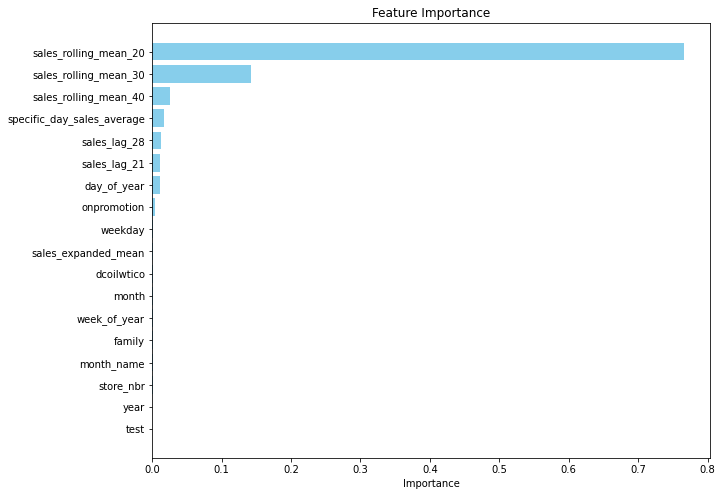

In [404]:
plot_feature_importance(model, X_train)

In [405]:
results_df

,Model,RMSLE,RMSE,MSE,MAE,MAE%
0,XGBoost,0.4,276.09,76226.06,70.96,14.72


## 4) Catboost

In [ ]:
# Transform sales column in training dataframe
train_df_log=train_df.copy()
train_df_log['sales']=np.log(train_df['sales']+1)
encode=False
cols_to_exclude=['quarter', 'weekday_name', 'city', 'state', 'store_type', 'cluster']

# Create dataset split
X_train, X_test, y_train, y_test= build_training_sets(train_df_log, cols_to_exclude, categorical_cols, encode)

In [ ]:
# evaluate the model
catboost_categorical_cols = [col for col in categorical_cols if col in X_train.columns]
model = CatBoostRegressor(cat_features=catboost_categorical_cols)  # Use GPU if available)

# Train the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame({'Model': ['CatBoost'],
                            'RMSLE': [rmsle],
                            'RMSE': [np.sqrt(mse)],
                            'MSE': [mse],
                            'MAE': [mae],
                            'MAE%': [mae_percentage]}).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

In [ ]:
# # Converting columns to standard notation
# cols = ['RMSE', 'MSE', 'MAE', 'MAE%']
# results_df[cols] = results_df[cols].applymap('{:.6f}'.format)
# results_df[cols] = results_df[cols].round(1)

In [ ]:
results_df

# Make Submission

In [406]:
# Sort train by id column
test_df = test_df.sort_values(by='id', ascending=True)
test_df.index = test_df['id']

# Remove the index name
test_df.index.name = None

In [407]:
# Make dataframe with id column
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'sales': np.nan
})

# Build training set
X = test_df.drop(['sales']+cols_to_exclude, axis=1)

# Make predictions
predictions = model.predict(X)

# Transform predictions back
predictions = np.exp(predictions) - 1

# Check predictions match number of entries
if len(predictions) != len(submission_df):

    print("Sizes dont match!")
    
else:

    # Assigning the array to the 'sales' column
    submission_df['sales'] = predictions

    print("Column successfully replaced")

# Output submission file
submission_df.to_csv('submission.csv', index=False)

Column successfully replaced
